In [164]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import fix_yahoo_finance as yf  
from scipy import stats
from bs4 import BeautifulSoup
import requests

In [165]:
df1 = pd.read_excel('TOP50_5Y_2.xlsx',sheetname='CLOSE_1D')
df1 = df1.set_index('Date')
Rf = df1['risk_free']/100/253

In [166]:
 #created a dataframe without risk

In [167]:
#calculate the returns for each stock
df2 = df1[df1.columns[:-1]]
tiker = df2.columns
returns = df2[tiker]/df2[tiker].shift(1)-1
#return2 = df1[tiker][:-1] / df1[tiker][1:].values - 1
returns = returns.dropna() #returns with Sp500
stock_returns = returns[returns.columns[:-1]].values #delete the column with s&p500

In [168]:
#first way to get beta: use covariance matrix
Y = returns['Sp500']
ticker_50=df1.columns[0:-2]
df_beta = pd.DataFrame(index=ticker_50, columns=['beta'])
for i in ticker_50:
    x = returns[i]
    cov_sm = np.cov(Y,x)[0,1]
    var_m = np.var(Y)
    Beta = cov_sm/var_m
    df_beta.loc[i] = pd.Series({'beta':Beta})

In [169]:
# #second way to get beta directly from yahooh finance
# tags = list()
# for i in ticker_50:
#     i = i.split()[0]
#     url = f'https://finance.yahoo.com/quote/{i}?p={i}'
#     response = requests.get(url)
#     results_page = BeautifulSoup(response.content,'lxml')
#     tag = results_page.find('td', {'data-test':'BETA_3Y-value'})
#     if len(tag) == 0 :
#         print(i)
#         tags.append(np.nan)
#     else:
#         tags.append(float(tag.get_text()))   

In [170]:
# #calculate the beta difference
# df_beta['yahoo_beta'] = tags
# df_beta['beta_diff'] = df_beta['beta']-df_beta['yahoo_beta']
# #the difference is acceptable, so we use the beta calculated by ourselves

# Using CAPM models for expected returns

In [171]:
# calculate the E(Ri) according to CAPM
# firstly, calculate the daily risk free rate
#secondly calculate returns for each stock
for i in returns.index:
    column_name = str(i)[:10]
    df_beta[column_name] = Rf[i] + df_beta['beta']*(Y[i]-Rf[i])
df_beta1 = df_beta.drop(['beta'], axis=1)
df_expected_return = df_beta1.T
return_mean = np.array([np.mean(df_expected_return).values])
return_mean = return_mean.T #calculate the expected return

In [172]:
print(np.max(return_mean))
print(np.min(return_mean))
#from this you could see that the biggest mean return is 0.0005761508320003633
#so when solving the qp, we should make the risk free rate go from 0.0002

0.0005442806456960392
0.00022703836957953678


[-4.32e-04 -3.29e-04 -3.99e-04 -4.26e-04 -4.41e-04 -3.98e-04 -2.74e-04 ... ]



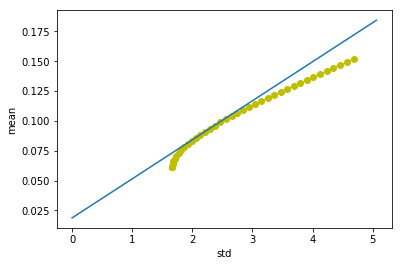

In [173]:
#first situation, short allowed, no risk-free assets
#sloving by optimize changing Rp
returns = np.asmatrix(stock_returns).T
cov = np.cov(returns)
P = opt.matrix(cov)
n = 50
avg_ret = return_mean
r_min = 0.0002
mus = []
for i in range(100):
    r_min += 0.00001
    mus.append(r_min)
G = opt.matrix(-(np.array(avg_ret))).T
print(G)
q = opt.matrix(np.zeros((n, 1)))

#h = opt.matrix(np.concatenate((-np.ones((1,1))*0.02,np.zeros((n,1))), 0))
A = opt.matrix(1.0, (1,n))
b = opt.matrix(1.0)
opt.solvers.options['show_progress'] = False
portfolio_weights = [solvers.qp(P, q, G,
                                opt.matrix(-np.ones((1,1))*yy), 
                                A, b)['x'] for yy in mus]
portfolio_returns = [(np.matrix(x).T * avg_ret)[0,0] for x in portfolio_weights]
portfolio_stdvs = [np.sqrt(np.matrix(x).T * cov.T.dot(np.matrix(x)))[0,0] for x in portfolio_weights]
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(np.sort(portfolio_stdvs)[:40]*253, np.sort(portfolio_returns)[:40]*253, 'y-o')
x1 = np.linspace(0,0.02,1000)
slope1 = 0.03274562 #calculated in later part
Rf_mean= np.mean(Rf)
y1 = x1*slope1+Rf_mean
x1 = [i*253 for i in x1]
y1 = [i*253 for i in y1]
#which is calculated in the part below, put it here to draw the two pictures together
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(x1,y1)

[-4.32e-04 -3.29e-04 -3.99e-04 -4.26e-04 -4.41e-04 -3.98e-04 -2.74e-04 ... ]



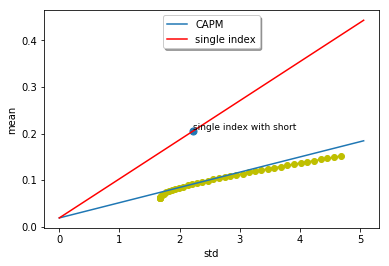

In [175]:
#first situation, short allowed, no risk-free assets
#sloving by optimize changing Rp
returns = np.asmatrix(stock_returns).T
cov = np.cov(returns)
P = opt.matrix(cov)
n = 50
avg_ret = return_mean
r_min = 0.0002
mus = []
for i in range(100):
    r_min += 0.00001
    mus.append(r_min)
G = opt.matrix(-(np.array(avg_ret))).T
print(G)
q = opt.matrix(np.zeros((n, 1)))

#h = opt.matrix(np.concatenate((-np.ones((1,1))*0.02,np.zeros((n,1))), 0))
A = opt.matrix(1.0, (1,n))
b = opt.matrix(1.0)
opt.solvers.options['show_progress'] = False
portfolio_weights = [solvers.qp(P, q, G,
                                opt.matrix(-np.ones((1,1))*yy), 
                                A, b)['x'] for yy in mus]
portfolio_returns = [(np.matrix(x).T * avg_ret)[0,0] for x in portfolio_weights]
portfolio_stdvs = [np.sqrt(np.matrix(x).T * cov.T.dot(np.matrix(x)))[0,0] for x in portfolio_weights]
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(np.sort(portfolio_stdvs)[:40]*253, np.sort(portfolio_returns)[:40]*253, 'y-o')
x1 = np.linspace(0,0.02,1000)
slope1 = 0.03274562 #calculated in later part
Rf_mean= np.mean(Rf)
y1 = x1*slope1+Rf_mean
x1 = [i*253 for i in x1]
y1 = [i*253 for i in y1]
#which is calculated in the part below, put it here to draw the two pictures together
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(x1,y1,label = 'CAPM')
#changed the daily return to annual return
ER_single =  20.492639010788864*0.01
sigma_single =  221.8983674722968*0.01
slope_single = (ER_single-Rf_mean*253)/sigma_single
y2 = np.array(x1)*slope_single+Rf_mean*253
plt.plot(x1,y2,color='r',label = 'single index')
plt.scatter(221.8983674722968*0.01,20.492639010788864*0.01, s=50)
plt.text(221.8983674722968*0.01,20.492639010788864*0.01,s ='single index with short' , va= 'bottom',fontsize=9)
plt.legend(loc='upper center', shadow=True)

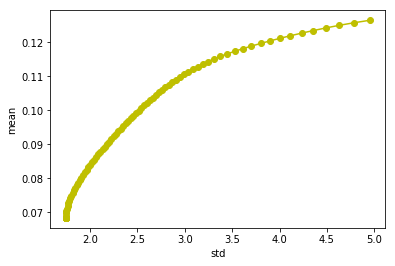

In [111]:
#third situation, short not allowed, no risk-free assets
#sloving by optimize changing Rp
returns = np.asmatrix(stock_returns).T
cov = np.cov(returns)
P = opt.matrix(cov)
n = 50
avg_ret = return_mean
r_min = 0.0002
mus = []
for i in range(100):
    r_min += 0.000003
    mus.append(r_min)
G = opt.matrix(np.concatenate((
                -np.transpose(np.array(avg_ret)), 
                -np.identity(n)), 0))
q = opt.matrix(np.zeros((n, 1)))
#h = opt.matrix(np.concatenate((-np.ones((1,1))*0.02,np.zeros((n,1))), 0))
A = opt.matrix(1.0, (1,n))
b = opt.matrix(1.0)
opt.solvers.options['show_progress'] = False
portfolio_weights = [solvers.qp(P, q, G,
                                opt.matrix(np.concatenate((-np.ones((1,1))*yy,np.zeros((n,1))), 0)), A, b)['x'] for yy in mus]
portfolio_returns = [(np.matrix(x).T * avg_ret)[0,0] for x in portfolio_weights]
portfolio_stdvs = [np.sqrt(np.matrix(x).T * cov.T.dot(np.matrix(x)))[0,0] for x in portfolio_weights]
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in portfolio_stdvs]
y = [i*253 for i in portfolio_returns]
plt.plot(x[:100],y[:100], 'y-o')

In [19]:
#first situation, short allowed, no risk-free assets
def optimal_portfolio(stock_returns):
    returns = np.asmatrix(stock_returns).T
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(return_mean)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    n=50
    # Create constraint matrices
    G = -opt.matrix(np.ones(n)).T  
    # negative n x n identity matrix
    h = opt.matrix(0.0, (1 ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
          for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns2 = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns2, risks, 2)
    return returns2, risks,m1

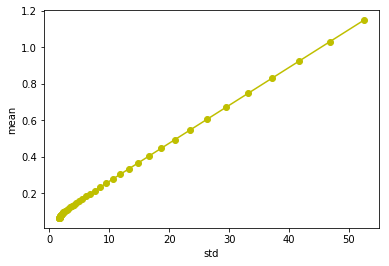

In [20]:
returns1, risks1,func= optimal_portfolio(stock_returns)
# plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in risks1]
y = [i*253 for i in returns1]
plt.plot(x[:50], y[:50], 'y-o')


     Returns  Volatility  Sharpe Ratio
32  0.000349    0.008403      0.032746


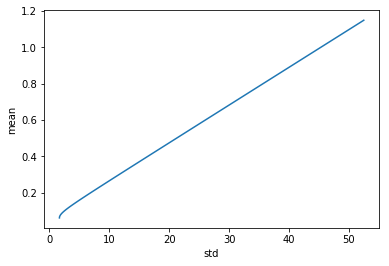

In [22]:
#second situation, short allowed, with risk-free assets
Rf_mean= np.mean(Rf)
sharpe1 = (returns1 - Rf_mean)/ risks1
portfolio = {'Returns': returns1,
             'Volatility':  risks1,
             'Sharpe Ratio': sharpe1}
df1 = pd.DataFrame(portfolio)
max_sharpe = df1['Sharpe Ratio'].max()
sharpe_portfolio = df1.loc[df1['Sharpe Ratio'] == max_sharpe]
print(sharpe_portfolio)
slope1 = (sharpe_portfolio['Returns'].values-Rf_mean)/sharpe_portfolio['Volatility'].values

x1 = np.linspace(0,0.002,1000)
y1 = x*slope1+Rf_mean
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(x,y)


In [152]:
#third situation, short not allowed, no risk-free assets
def optimal_portfolio2(stock_returns):
    returns = np.asmatrix(stock_returns).T
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(return_mean)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    # Create constraint matrices
    G = -opt.matrix(np.identity(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
          for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns2 = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns2, risks, 2)
#     x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
#     wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return returns2, risks

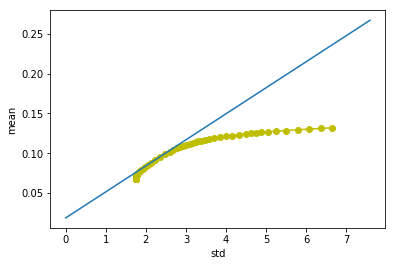

In [160]:
returns2, risks2 = optimal_portfolio2(stock_returns)
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in risks2]
y = [i*253 for i in returns2]
plt.plot(x[:100],y[:100], 'y-o')
x4 = np.linspace(0,0.03,1000)
slope = 0.03274529 #which is calculated in the part below, put it here to draw the two pictures together
Rf_mean= np.mean(Rf)
y4 = x4*slope+Rf_mean
x4 = [i*253 for i in x4]
y4 = [i*253 for i in y4]
plt.plot(x4,y4,label = 'CAPM')

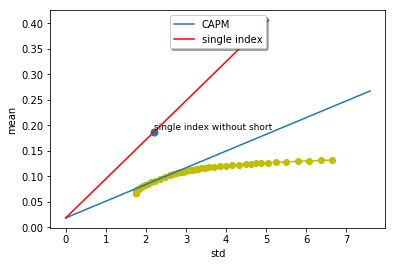

In [176]:
returns2, risks2 = optimal_portfolio2(stock_returns)
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in risks2]
y = [i*253 for i in returns2]
plt.plot(x[:100],y[:100], 'y-o')
x4 = np.linspace(0,0.03,1000)
slope = 0.03274529 #which is calculated in the part below, put it here to draw the two pictures together
Rf_mean= np.mean(Rf)
y4 = x4*slope+Rf_mean
x4 = [i*253 for i in x4]
y4 = [i*253 for i in y4]
plt.plot(x4,y4,label = 'CAPM')
ER_single =  18.715403403443226*0.01
sigma_single = 220.184786494889*0.01
slope_single = (ER_single- Rf_mean*253)/sigma_single
y2 = np.array(x1)*slope_single+Rf_mean*253
plt.plot(x1,y2,color='r',label = 'single index')
plt.scatter(220.184786494889*0.01,18.715403403443226*0.01, s=50)
plt.text(220.184786494889*0.01,18.715403403443226*0.01,s ='single index without short' , va= 'bottom',fontsize=9)
plt.legend(loc='upper center', shadow=True)

     Returns  Volatility  Sharpe Ratio
32  0.000349    0.008405      0.032745
[0.03274529]


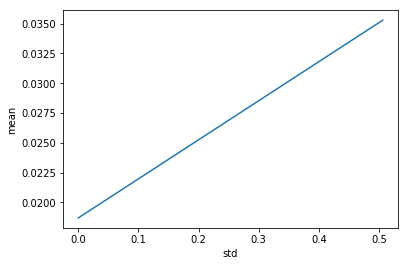

In [25]:
#fourhh situation, short not allowed, with risk-free assets
Rf_mean= np.mean(Rf)
sharpe2 = (returns2 - Rf_mean)/ risks2
portfolio = {'Returns': returns2,
             'Volatility':  risks2,
             'Sharpe Ratio': sharpe2}
df2 = pd.DataFrame(portfolio)
max_sharpe = df2['Sharpe Ratio'].max()
sharpe_portfolio = df2.loc[df2['Sharpe Ratio'] == max_sharpe]
print(sharpe_portfolio)
slope = (sharpe_portfolio['Returns'].values-Rf_mean)/sharpe_portfolio['Volatility'].values
print(slope)
x = np.linspace(0,0.002,1000)
y = x*slope+Rf_mean
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in x]
y = [i*253 for i in y]
plt.plot(x,y)

# Using APT models for expected returns


In [26]:
df_apt = pd.read_csv('PredictRi_APT.csv')

In [27]:
df_apt = df_apt.dropna()

In [28]:

print(len(df_apt.columns))

51


In [37]:
new_columns = df_apt.columns.values
new_columns[0] = 'index1'
df_apt.columns = new_columns
df_apt1 = df_apt.set_index('index1')
return_mean = np.array([np.mean(df_apt1).values])

return_mean_apt = return_mean.T

In [38]:
print(len(return_mean_apt))

50


In [85]:
#first situation, short allowed, no risk-free assets
def optimal_portfolio3(stock_returns):
    returns = np.asmatrix(stock_returns).T
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(return_mean_apt)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    # Create constraint matrices
    G = -opt.matrix(np.ones(n)).T  
    # negative n x n identity matrix
    h = opt.matrix(0.0, (1 ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
          for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    return returns, risks

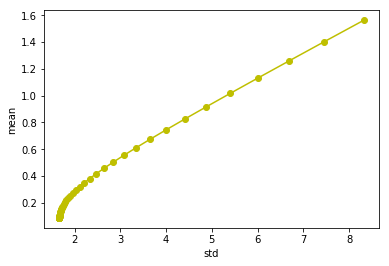

In [99]:
returns3, risks3= optimal_portfolio3(stock_returns)

# plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
returns3 = [i*253 for i in returns3]
risks3 = [i*253 for i in risks3]
plt.plot(np.sort(risks3)[:65],np.sort(returns3)[:65], 'y-o')
# x = np.linspace(0,8,1000)
# max_sharpe= 0.1855893721716131
# Rf_mean= np.mean(Rf)
# y = x*max_sharpe+Rf_mean
# plt.ylabel('mean')
# plt.xlabel('std')
# plt.plot(x,y)

7.393663764882756e-05
[0.18138803 0.18140545 0.18142496 0.1814468  0.18147123 0.18149856
 0.18152912 0.18156326 0.18160141 0.181644   0.18169151 0.18174448
 0.18180349 0.18186915 0.18194215 0.1820232  0.18211306 0.18221252
 0.18232239 0.18244352 0.18257669 0.18272268 0.18288214 0.1830556
 0.18324335 0.18344532 0.183661   0.18388924 0.184128   0.18437412
 0.18462293 0.18486781 0.18509967 0.1853063  0.18547163 0.18557481
 0.18558937 0.18548219 0.18521268 0.18473222 0.18398406 0.18290408
 0.1814228  0.17946885 0.17697427 0.1738813  0.17015035 0.16576766
 0.16075145 0.15515462 0.14906308 0.14258961 0.13586405 0.12902196
 0.12219362 0.11549527 0.10902344 0.10285239 0.09703434 0.09160149
 0.08656909 0.0819389  0.07770249 0.07384418 0.07034353 0.06717726
 0.06432074 0.06174905 0.05943775 0.05736341 0.05550388 0.05383849
 0.05234814 0.0510153  0.04982396 0.04875956 0.04780893 0.04696018
 0.04620258 0.04552648 0.04492324 0.04438508 0.04390504 0.04347689
 0.04309507 0.04275458 0.04245098 0.04218

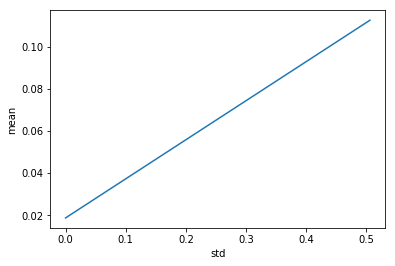

In [57]:
#second situation, short allowed, with risk-free assets
Rf_mean= np.mean(Rf)
print(Rf_mean)
sharpe3 = (returns3 - Rf_mean)/ risks3
print(sharpe3)
portfolio = {'Returns': returns3,
             'Volatility':  risks3,
             'Sharpe Ratio': sharpe3}
df3 = pd.DataFrame(portfolio)
max_sharpe = df3['Sharpe Ratio'].max()
print(max_sharpe)
sharpe_portfolio = df3.loc[df3['Sharpe Ratio'] == max_sharpe]
print(sharpe_portfolio)
x = np.linspace(0,0.002,1000)
y = x*max_sharpe+Rf_mean
print(max_sharpe)
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in x]
y = [i*253 for i in y]
plt.plot(x,y)

In [61]:
#third situation, short not allowed, no risk-free assets
def optimal_portfolio2(stock_returns):
    returns = np.asmatrix(stock_returns).T
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(return_mean_apt)
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    # Create constraint matrices
    G = -opt.matrix(np.identity(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
          for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns2 = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns2, risks, 2)
#     x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
#     wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return returns2, risks

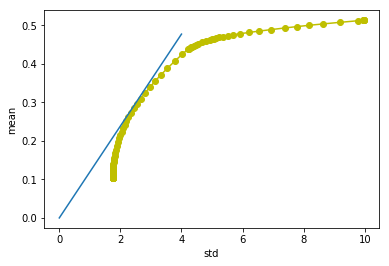

In [68]:
returns4, risks4 = optimal_portfolio2(stock_returns)
plt.ylabel('mean')
plt.xlabel('std')
plt.xlabel('std')
returns4 = [i*253 for i in returns4]
risks4 = [i*253 for i in risks4]
plt.plot(risks4,returns4, 'y-o')
x = np.linspace(0,4,1000)
slope = 0.11929257
Rf_mean= np.mean(Rf)
y = x*slope+Rf_mean
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(x,y)

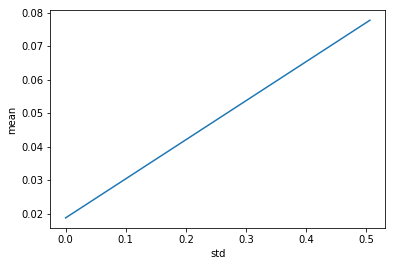

In [69]:
#fourth situation, short not allowed, with risk-free assets
Rf_mean= np.mean(Rf)

sharpe4 = (returns4 - Rf_mean)/ risks4
portfolio = {'Returns': returns4,
             'Volatility':  risks4,
             'Sharpe Ratio': sharpe4}
df4 = pd.DataFrame(portfolio)
max_sharpe = df4['Sharpe Ratio'].max()
sharpe_portfolio = df4.loc[df4['Sharpe Ratio'] == max_sharpe]
slope = (sharpe_portfolio['Returns'].values-Rf_mean)/sharpe_portfolio['Volatility'].values
x = np.linspace(0,0.002,1000)
y = x*slope+Rf_mean
plt.ylabel('mean')
plt.xlabel('std')
x = [i*253 for i in x]
y = [i*253 for i in y]
plt.plot(x,y)